## Calculating the Slope in a PSD in log-log space
3 May 2019

Notebook to show how to calculate the slope of a PSD in log-log space with the following steps:
1. smooth the PSD (boxcar smoothing vs. averaging binned data points--30 data points in each bin)
2. Perform linear fit in log-log space

In [1]:
from analysis import *
from astropy.convolution import convolve, Box1DKernel # for boxcar smoothing 

import everest 

import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

import richardsplot

In [2]:
epic = 220293277 # some faint object in k2 campaign 8
campaign = 8

# load in some sample light curve
lc = lk.search_targetpixelfile(epic, campaign=campaign).download().to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences


# calculate the PSD
# gotta convert days into sec
freq, power = LS_PSD(lc.time[~spurious_cadences]*86400, lc.flux[~spurious_cadences], f=k2_freq)

Text(0.5, 1.0, 'EPIC 220293277 PSD')

/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/rachel/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


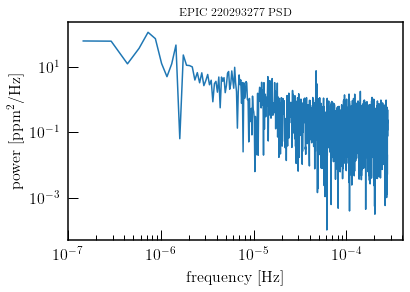

In [3]:
plt.plot(freq, power)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("frequency [Hz]")
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.title("EPIC %s PSD"%epic)

Now let's try our two methods of smoothing to compare.

In [4]:
# boxcar smoothing
N = 15
p_smooth_boxcar = convolve(power, Box1DKernel(N), boundary='extend')
# (nice and straghtforward)

In [5]:
# binning w/ defined bin-size
N = 30
f_smooth_bin = []
p_smooth_bin = []

i = 0
while i < len(freq):
    if i+N > len(freq):
        f_smooth_bin.append(np.average(freq[i:]))
        p_smooth_bin.append(np.average(power[i:]))
    else:
        f_smooth_bin.append(np.average(freq[i:i+N]))
        p_smooth_bin.append(np.average(power[i:i+N]))
    i += N

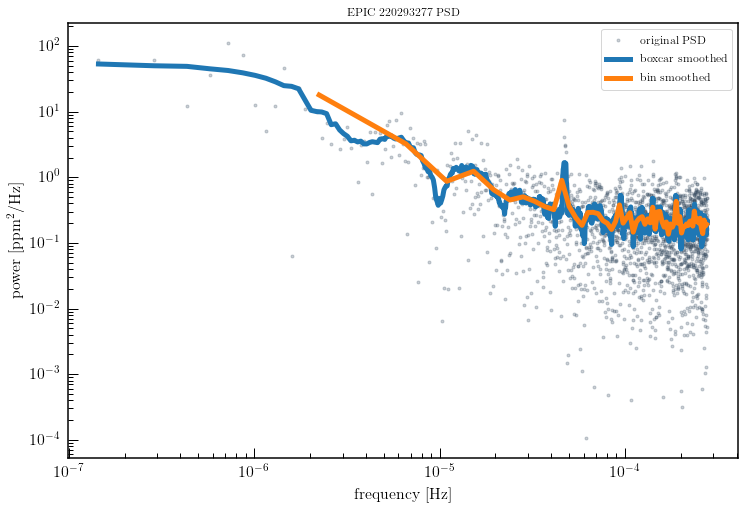

In [6]:
plt.figure(figsize=(12,8))
plt.plot(freq, power, marker='.', ls='', color='#34495e', alpha=0.25, label="original PSD")
plt.plot(freq, p_smooth_boxcar, linewidth=5, alpha=1.0, label="boxcar smoothed")
plt.plot(f_smooth_bin, p_smooth_bin, linewidth=5, alpha=1.0, label="bin smoothed")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("frequency [Hz]")
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.title("EPIC %s PSD"%epic)
plt.legend()

Fit a line in log-log space.

In [7]:
# transform smoothed data into log-log space 
freq_log = np.log10(freq)
p_log_box = np.log10(p_smooth_boxcar)

f_log_bin = np.log10(f_smooth_bin)
p_log_bin = np.log10(p_smooth_bin)

# perform the fit
fit_box = np.polyfit(freq_log, p_log_box, 1)
fit_bin = np.polyfit(f_log_bin, p_log_bin, 1)

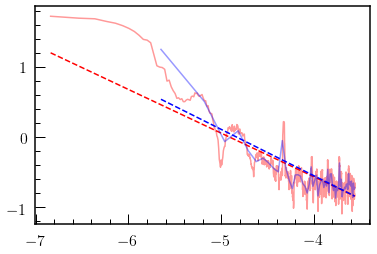

In [8]:
# preliminary plot
plt.plot(freq_log, p_log_box, 'r-', alpha=0.4)
plt.plot(freq_log, freq_log*fit_box[0]+fit_box[1], 'r--')

plt.plot(f_log_bin, p_log_bin, 'b-', alpha=0.4)
plt.plot(f_log_bin, f_log_bin*fit_bin[0]+fit_bin[1], 'b--')

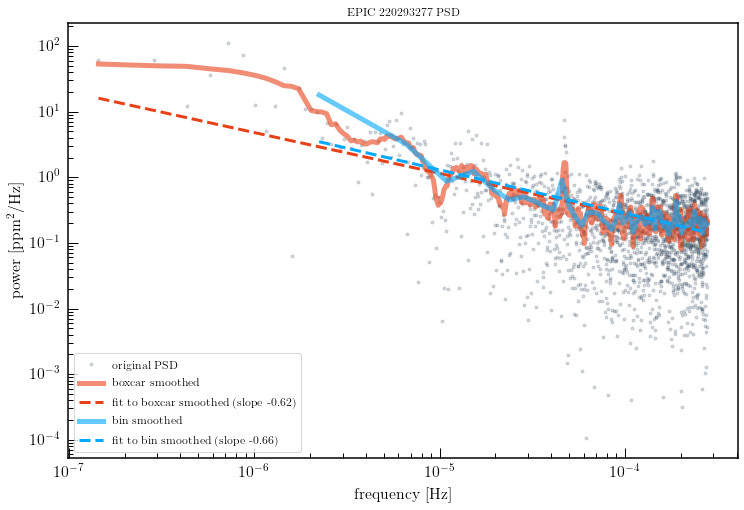

In [9]:
# convert it back from log-log space to plot consistently
p_fit_box = 10**(freq_log*fit_box[0]+fit_box[1])
p_fit_bin = 10**(f_log_bin*fit_bin[0]+fit_bin[1])


plt.figure(figsize=(12,8))
plt.plot(freq, power, marker='.', ls='', color='#34495e', alpha=0.2, label="original PSD")

plt.plot(freq, p_smooth_boxcar, color='#e84118', linewidth=5, alpha=0.6, label="boxcar smoothed")
plt.plot(freq, p_fit_box, color='#e84118', ls='--', linewidth=3, label="fit to boxcar smoothed (slope %.2f)"%fit_box[0])

plt.plot(f_smooth_bin, p_smooth_bin, color='#00a8ff', linewidth=5, alpha=0.6, label="bin smoothed")
plt.plot(f_smooth_bin, p_fit_bin,  color='#00a8ff', ls='--', linewidth=3, label="fit to bin smoothed (slope %.2f)"%fit_bin[0])

plt.xscale('log')
plt.yscale('log')
plt.xlabel("frequency [Hz]")
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.title("EPIC %s PSD"%epic)
plt.legend()

Looks good.


---
Below, I draft putting it into function form that will be added to ```analysis.py``` when complete.

In [10]:
def bin_smoothing(x,y, N=30):
    """
    Function to perform smoothing on a dataset 
    Computes the average of bins for data binned with N data points.
    (Note: takes both x and y to make my life easier)
    
    args
        x : array of x dimension of the data
        y : array of y dimension of the data
        N : number of data points in bin (default N = 30)
    returns
        x_smooth : smoothed x-array
        y_smooth : smoothed y-array
    """
    x_smooth = []
    y_smooth = []

    i = 0
    while i < len(x):
        if i+N > len(x):
            x_smooth.append(np.average(x[i:]))
            y_smooth.append(np.average(y[i:]))
        else:
            x_smooth.append(np.average(x[i:i+N]))
            y_smooth.append(np.average(y[i:i+N]))
        i += N
        
    return np.array(x_smooth), np.array(y_smooth)

def smooth_fit(x, y, smoothing='boxcar', N=30):
    """
    Function to smooth and perform linear fit to x,y data
    
    args
        x : array of x dimension of the data
        y : array of y dimension of the data
        smoothing : method to smooth the data
            'boxcar' : (default) smoothed data is same size as input data
            'bin' : (see bin_smoothing) smoothed data is smaller shape than input data

    returns
        m : slope of smoothed fit
        b : y-intercept of smoothed fit
    """
    
    # smooth
    if smoothing=='boxcar':
        # boxcar smoothing
        y_smooth = convolve(y, Box1DKernel(N), boundary='extend')
        x_smooth = x
    elif smoothing=='bin':
        x_smooth, y_smooth = bin_smoothing(x,y,N)
        #print(x_smooth)
    else:
        raise ValueError("Invalid smoothing type specified '%s'"%smoothing)
        
        
    # fit 
    m, b = np.polyfit(x_smooth, y_smooth, 1)
    
    return m,b

We've seen that there's a difference in the fits performed on different smoothing. But, how much of a difference when doing a fit compared to the raw? Let's see!

In [11]:
m0,b0 = np.polyfit(np.log10(freq), np.log10(power), 1)
print ("raw: m=%s, b=%s"%(m0,b0))
m,b = smooth_fit(np.log10(freq), np.log10(power),smoothing='boxcar')
print ("boxcar: m=%s, b=%s, slope difference = %s"%(m,b,m-m0))
m,b = smooth_fit(np.log10(freq), np.log10(power),smoothing='bin')
print ("bin: m=%s, b=%s, slope difference = %s"%(m,b,m-m0))

raw: m=-0.6049969678443557, b=-3.2143853663466437
boxcar: m=-0.6079964117363195, b=-3.2254281994007195, slope difference = -0.0029994438919637156
bin: m=-0.5984521595642065, b=-3.1882353264794174, slope difference = 0.00654480828014925


Yes, smoothing does make a difference, though not a huge one.

---
5 days is the expected noise floor. We want to fit a slope to freqencies >5 days (to see if it's flat) and a slope to frequencies <5 days.

In [12]:
noise_floor_days = 5
# noise floor are freqencies > X days, convert to Hz
noise_floor_mask = freq>2*np.pi/(noise_floor_days*86400)

m, b = np.polyfit(np.log10(freq)[~noise_floor_mask], np.log10(power)[~noise_floor_mask], 1)
m_noise, b_noise = np.polyfit(np.log10(freq)[noise_floor_mask], np.log10(power)[noise_floor_mask], 1)

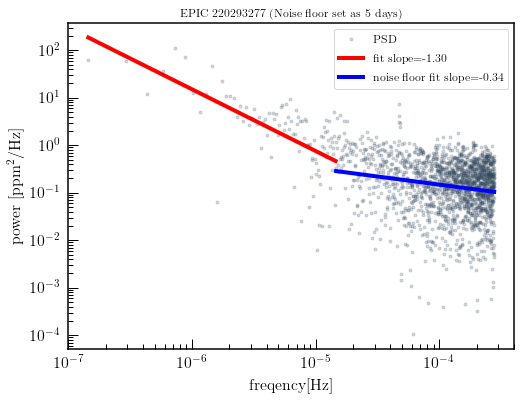

In [15]:
plt.figure(figsize=(8,6))

plt.plot(freq, power,marker='.', ls='', color='#34495e', alpha=0.2,label="PSD")
plt.plot(freq[~noise_floor_mask], 10**(np.log10(freq[~noise_floor_mask])*m+b), 'r-', linewidth=4, label="fit slope=%.2f"%m)
plt.plot(freq[noise_floor_mask], 10**(np.log10(freq[noise_floor_mask])*m_noise+b_noise), 'b-', linewidth=4, label="noise floor fit slope=%.2f"%m_noise)
plt.xscale('log')
plt.yscale('log')

plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("freqency[Hz]")
plt.title("EPIC %s (Noise floor set as %s days)"%(epic, noise_floor_days))
plt.legend()
plt.savefig("/home/rachel/Research/K2/submit/PSD_slope_ex.png")

What does it look like for a corrected light curve?

In [71]:
everest.Search(epic)

Searching for target 220293277...
Target is in campaign 8 of the EVEREST catalog.


In [72]:
lc_everest = everest.Everest(epic, season=campaign)

INFO  [everest.user.DownloadFile()]: Downloading the file...
INFO  [everest.user.load_fits()]: Loading FITS file for 220293277.


Text(0.5, 1.0, 'EPIC 220293277 Corrected Light curve')

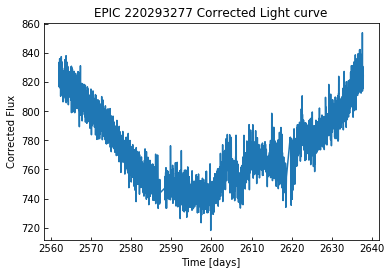

In [83]:
cad = np.arange(3852+1)
flux_pld = lc_everest.flux

# turning indices found to be "bad" into a boolen mask to apply
mask = (np.isin(cad, np.concatenate([lc_everest.nanmask, lc_everest.badmask, lc_everest.mask])))

# interpolate the spurious cadences
interped_vals = np.interp(cad[mask], cad[~mask], flux_pld[~mask])
# replace spurious cadence values with the interpolated values
flux_pld[mask] = interped_vals

# 30 mintue intervals between cadences 
cutoff_day = 3*24*2
#cutoff = np.logical_and(cad>cutoff_day, cad<cad[-1]-5*cutoff_day)
cutoff = cad>cutoff_day
# finding linear fit 
m,b = np.polyfit(cad[cutoff], flux_pld[cutoff], 1)

# subtracting it
flux_corrected = flux_pld[cutoff] - (m*cad[cutoff])

# plot
plt.plot(lc_everest.time[cutoff], flux_corrected)
plt.xlabel("Time [days]")
plt.ylabel("Corrected Flux")
plt.title("EPIC %s Corrected Light curve"%epic)

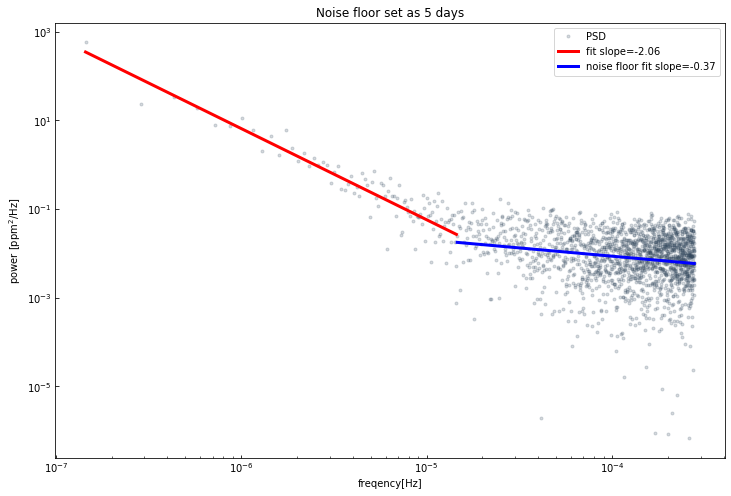

In [82]:
f,p = LS_PSD(lc_everest.time[cutoff]*86400, flux_pld[cutoff], f=k2_freq)

# noise floor
noise_floor_days = 5
# noise floor are freqencies > X days, convert to Hz
noise_floor_mask2 = f>2*np.pi/(noise_floor_days*86400)

m2, b2 = np.polyfit(np.log10(f)[~noise_floor_mask2], np.log10(p)[~noise_floor_mask2], 1)
m_noise2, b_noise2 = np.polyfit(np.log10(f)[noise_floor_mask2], np.log10(p)[noise_floor_mask2], 1)


# plot
plt.figure(figsize=(12,8))
plt.plot(f,p,marker='.', ls='', color='#34495e', alpha=0.2,label="PSD")
plt.plot(f[~noise_floor_mask2], 10**(np.log10(f[~noise_floor_mask2])*m2+b2), 'r-', linewidth=3, label="fit slope=%.2f"%m2)
plt.plot(f[noise_floor_mask2], 10**(np.log10(f[noise_floor_mask2])*m_noise2+b_noise2), 'b-', linewidth=3, label="noise floor fit slope=%.2f"%m_noise2)
plt.xscale('log')
plt.yscale('log')

plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("freqency[Hz]")
plt.title("Corrected Lightcurve PSD")
plt.legend()

The fit to the noise floor doesn't necessarily have a flat slope. What does it look like with smoothing?

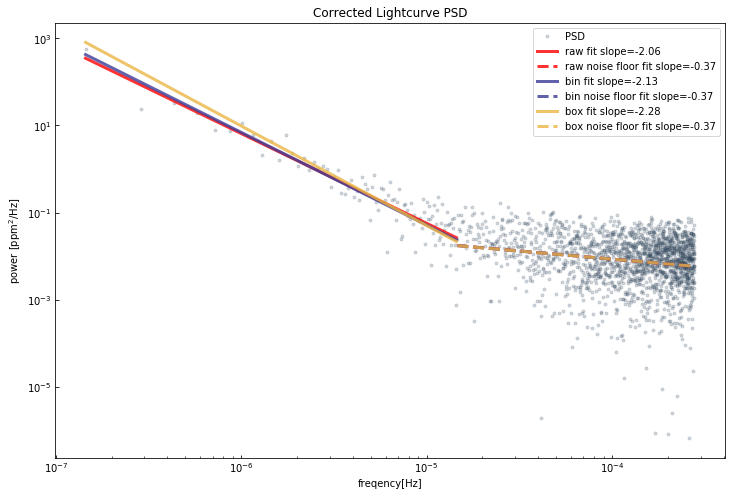

In [91]:
# Above the noise floor
m_bin,b_bin = smooth_fit(np.log10(f[~noise_floor_mask2]), np.log10(p[~noise_floor_mask2]),smoothing='bin')
m_box,b_box = smooth_fit(np.log10(f[~noise_floor_mask2]), np.log10(p[~noise_floor_mask2]),smoothing='boxcar')

# below the noise floor
m_bin_n,b_bin_n = smooth_fit(np.log10(f[noise_floor_mask2]), np.log10(p[noise_floor_mask2]),smoothing='bin')
m_box_n,b_box_n = smooth_fit(np.log10(f[noise_floor_mask2]), np.log10(p[noise_floor_mask2]),smoothing='boxcar')


# plot
plt.figure(figsize=(12,8))
plt.plot(f,p,marker='.', ls='', color='#34495e', alpha=0.2,label="PSD")
plt.plot(f[~noise_floor_mask2], 10**(np.log10(f[~noise_floor_mask2])*m2+b2), 'r-', linewidth=3, alpha=0.8,label="raw fit slope=%.2f"%m2)
plt.plot(f[noise_floor_mask2], 10**(np.log10(f[noise_floor_mask2])*m_noise2+b_noise2), 'r--', linewidth=3, alpha=0.8,label="raw noise floor fit slope=%.2f"%m_noise2)

plt.plot(f[~noise_floor_mask2], 10**(np.log10(f[~noise_floor_mask2])*m_bin+b_bin), color='#3B3B98', ls='-', linewidth=3, alpha=0.8,label="bin fit slope=%.2f"%m_bin)
plt.plot(f[noise_floor_mask2], 10**(np.log10(f[noise_floor_mask2])*m_bin_n+b_bin_n), color='#3B3B98', ls='--', linewidth=3, alpha=0.8,label="bin noise floor fit slope=%.2f"%m_bin_n)

plt.plot(f[~noise_floor_mask2], 10**(np.log10(f[~noise_floor_mask2])*m_box+b_box), color='#EAB543', ls='-', linewidth=3, alpha=0.8, label="box fit slope=%.2f"%m_box)
plt.plot(f[noise_floor_mask2], 10**(np.log10(f[noise_floor_mask2])*m_box_n+b_box_n), color='#EAB543', ls='--', linewidth=3, alpha=0.8,label="box noise floor fit slope=%.2f"%m_box_n)

plt.xscale('log')
plt.yscale('log')

plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("freqency[Hz]")
plt.title("Corrected Lightcurve PSD")
plt.legend()

Smoothing doesn't make a difference for data below the noise floor (probably because there's so many data points), but does affect the slope we measure above the noise floor.